# Shared Experiment Analysis

Things this notebook does:

- Creates shared plots that look better and use shared legend
- Creates plot which shows average normalized performance across environments.

In [1]:
import copy
from dataclasses import dataclass
import os.path as osp
from pprint import pprint
import sys
from typing import Dict, List, Tuple, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# disable annoying warning
pd.options.mode.chained_assignment = None

import posggym_agents

import potmmcp.plot as plot_utils
import potmmcp.plot.paper as paper_utils
from potmmcp.config import BASE_REPO_DIR

# import experiment parameters for each env
sys.path.append(osp.join(BASE_REPO_DIR, "experiments"))
import common
import run_driving_exp as driving
import run_pe_evader_exp as pe_evader
import run_pe_pursuer_exp as pe_pursuer
import run_pp2_exp as pp2
import run_pp4_exp as pp4

TINY_SIZE = 10
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TINY_SIZE)     # fontsize of the tick labels
plt.rc('ytick', labelsize=TINY_SIZE)     # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# For UAI paper formatting
PAGE_WIDTH = 6.75  # inches
PAGE_COL_WIDTH = (6.75 - 0.25) / 2

algname = "POTMMCP"
baselinealgname = "I-POMCP-PF"

BASE_EXP_DIR = osp.join(BASE_REPO_DIR, "experiments")
ENV_RESULTS_DIR = osp.join(BASE_EXP_DIR, "results")
POSGGYM_AGENTS_DIR = osp.join(posggym_agents.config.BASE_DIR, 'agents')

figure_dir = osp.join(BASE_EXP_DIR, "shared_figures")

In [2]:
@dataclass
class EnvInfo:
    id: str
    label: str
    id_short: str
    exp_params: common.EnvExperimentParams
    policy_results_file: str
    
    @property
    def results_dir(self) -> str:
        return osp.join(ENV_RESULTS_DIR, self.id_short)
    
    @property
    def baseline_avg_exp_results_file(self) -> str:
        return osp.join(self.results_dir, "baseline_avg_performance_results.csv")
    
    @property
    def meta_avg_exp_results_file(self) -> str:
        return osp.join(self.results_dir, "meta_avg_performance_results.csv")

    
# Analysis relevant info for each experiment environment
env_info_map = {
    "driving": EnvInfo(
        id=driving.ENV_ID,
        label="Driving",
        id_short="driving",
        exp_params=driving.DRIVING_EXP_PARAMS,
        policy_results_file=osp.join(
            POSGGYM_AGENTS_DIR, "driving14x14wideroundabout_n2_v0",  "results", "klrbr_results.csv"
        ),
    ),
    "pe_evader": EnvInfo(
        id=pe_evader.ENV_ID,
        label="PE (Evader)",
        id_short="pe_evader",
        exp_params=pe_evader.PE_EVADER_EXP_PARAMS,
        policy_results_file=osp.join(
            POSGGYM_AGENTS_DIR, "pursuitevasion16x16_v0", "results", "pairwise_results.csv"
        ),
    ),
    "pe_pursuer": EnvInfo(
        id=pe_pursuer.ENV_ID,
        label="PE (Pursuer)",
        id_short="pe_pursuer",
        exp_params=pe_pursuer.PE_PURSUER_EXP_PARAMS,
        policy_results_file=osp.join(
            POSGGYM_AGENTS_DIR, "pursuitevasion16x16_v0", "results", "pairwise_results.csv"
        ),
    ),
    "pp2": EnvInfo(
        id=pp2.ENV_ID,
        label="PP (two-agents)",
        id_short="pp2",
        exp_params=pp2.PP2_EXP_PARAMS,
        policy_results_file=osp.join(
            POSGGYM_AGENTS_DIR, "predatorprey10x10_P2_p3_s2_coop_v0", "results", "pairwise_results.csv"
        ),
    ),
    "pp4": EnvInfo(
        id=pp4.ENV_ID,
        label="PP (four-agents)",
        id_short="pp4",
        exp_params=pp4.PP4_EXP_PARAMS,
        policy_results_file=osp.join(
            POSGGYM_AGENTS_DIR, "predatorprey10x10_P4_p3_s3_coop_v0", "results", "pairwise_results.csv"
        ),
    ),
}

## Load Results

In [3]:
# helper functions
def get_df_info(df):
    alg_ids = df["alg_id"].unique().tolist()
    alg_ids.sort()
    print("Alg IDs")
    print("-------")
    for n in alg_ids:
        print(n)

    policy_ids = df["policy_id"].unique().tolist()
    policy_ids.sort()
    print("\nPolicy IDs")
    print("----------")
    for n in policy_ids:
        print(n)

        
def remove_agent_id(row):
    pi_id = row["policy_id"]
    tokens = pi_id.split("_")
    id_token = [t for t in tokens if t.startswith("i")]
    if len(id_token):
        tokens.remove(id_token[0])
    return "_".join(tokens)


def add_standardized_return(row, return_means):
    n = row["search_time_limit"]
    return (row["episode_return_mean"] - return_means[n]) / row["episode_return_std"]


def add_standardized_CI(row):
    std = 1.0
    n = row["num_episodes"]
    return 1.96 * (std / np.sqrt(n))


baseline_exp_dfs = {
    env_id: pd.read_csv(env_info.baseline_avg_exp_results_file) for env_id, env_info in env_info_map.items()
}
for env_id, env_df in baseline_exp_dfs.items():
    env_df["policy_id"] = env_df.apply(remove_agent_id, axis=1)

meta_exp_dfs = {
    env_id: pd.read_csv(env_info.meta_avg_exp_results_file) for env_id, env_info in env_info_map.items()
}
for env_id, env_df in meta_exp_dfs.items():
    env_df["policy_id"] = env_df.apply(remove_agent_id, axis=1)

# Meta-Policy Performance

In [4]:
meta_pi_label_map = {
    "greedy": r"$\sigma_{i}^{0}$",
    "softmax": r"$\sigma_{i}^{0.25}$",
    "uniform": r"$\sigma_{i}^{\infty}$",
}


def get_meta_pi_df(df):
    df = df[(df["alg_id"] == "baposgmcp") & (df["truncated"] == True)]
    
    search_times = df["search_time_limit"].unique().tolist()
    search_times.sort()
    
    return_means = {}
    for n in search_times:
        n_df = df[df["search_time_limit"] == n]
        return_means[n] = df["episode_return_mean"].mean()
    
    df["standardized_episode_return_mean"] = df.apply(
        lambda row: add_standardized_return(row, return_means), axis=1
    )
    df["standardized_episode_return_CI"] = df.apply(
        lambda row: add_standardized_CI(row), axis=1
    )
    return df


meta_pi_dfs = {}
for env_id, env_df in meta_exp_dfs.items():
    env_info = env_info_map[env_id]
    print(env_id, env_info.label)
    meta_pi_dfs[env_info.label] = get_meta_pi_df(env_df)

driving Driving
pe_evader PE (Evader)
pe_pursuer PE (Pursuer)
pp2 PP (two-agents)
pp4 PP (four-agents)


## Meta-Policy Performance by environment

Performance of POTMMCP with each meta-policy, in each environment.

Driving
PE (Evader)
PE (Pursuer)
PP (two-agents)
PP (four-agents)


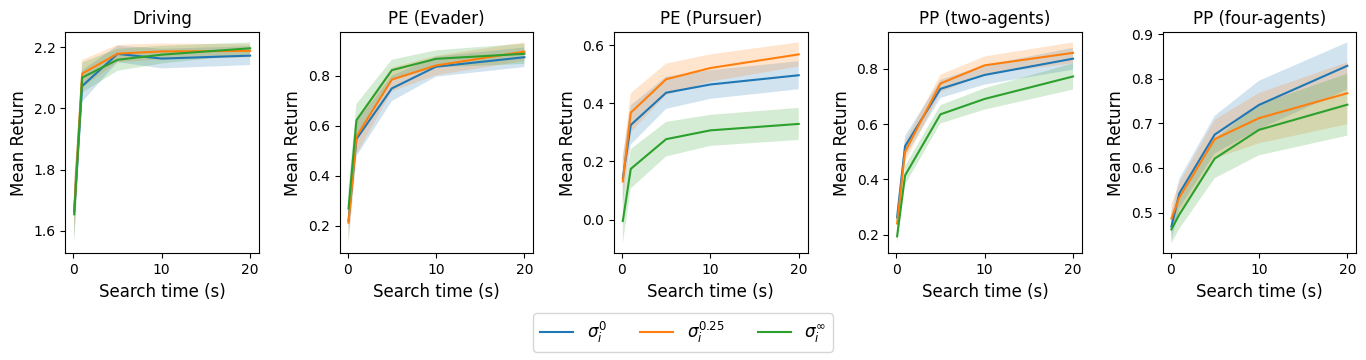

In [6]:
fig_kwargs = {"figsize": (PAGE_WIDTH*2, 3.5)}
subplot_kwargs = {
    "ylabel": "Mean Return",
    "xlabel": "Search time (s)"
}

num_rows = 1
num_cols = len(meta_pi_dfs)

fig, axs = plt.subplots(
    nrows=num_rows,
    ncols=num_cols,
    squeeze=False,
    subplot_kw=subplot_kwargs,
    **fig_kwargs,
)

for i, (env_label, env_df) in enumerate(meta_pi_dfs.items()):
    print(env_label)
    ax = axs[0][i]
    paper_utils.plot_meta_policy_performance(
        env_df,
        ax=ax,
        x_key="search_time_limit",
        y_key="episode_return_mean",
        y_err_key="episode_return_CI",
        meta_pi_label_map=meta_pi_label_map,
    )
    ax.set_title(env_label)
    
handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=5, loc="lower center")

fig.tight_layout(pad=0.1, w_pad=0.8, h_pad=1.0, rect=(0.0, 0.16, 1.0, 1.0))
fig.savefig(osp.join(figure_dir, "shared_meta_pi_return.png"))

## Standardized Meta-Policy Performance

Performance of POTMMCP with each meta-policy, averaged across environments.

In [7]:
meta_pi_df = pd.concat(list(meta_pi_dfs.values()))
get_df_info(meta_pi_df)
    
agg_dict = plot_utils.get_uniform_expected_agg_map(meta_pi_df)
gb = meta_pi_df.groupby(["policy_id"])
gb_agg = gb.agg(**agg_dict)

print("\nUngrouped size =", len(meta_pi_df))
meta_pi_exp_df = gb_agg.reset_index()
print("Grouped size =", len(meta_pi_exp_df ))

new_policies = set(meta_pi_exp_df ["policy_id"].unique().tolist())
assert len(new_policies) == len(meta_pi_exp_df ), "Should be one row per policy ID"

Alg IDs
-------
baposgmcp

Policy IDs
----------
baposgmcp_metagreedy_searchtimelimit0.1_truncatedTrue
baposgmcp_metagreedy_searchtimelimit10_truncatedTrue
baposgmcp_metagreedy_searchtimelimit1_truncatedTrue
baposgmcp_metagreedy_searchtimelimit20_truncatedTrue
baposgmcp_metagreedy_searchtimelimit5_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit0.1_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit10_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit1_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit20_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit5_truncatedTrue
baposgmcp_metauniform_searchtimelimit0.1_truncatedTrue
baposgmcp_metauniform_searchtimelimit10_truncatedTrue
baposgmcp_metauniform_searchtimelimit1_truncatedTrue
baposgmcp_metauniform_searchtimelimit20_truncatedTrue
baposgmcp_metauniform_searchtimelimit5_truncatedTrue

Ungrouped size = 75
Grouped size = 15


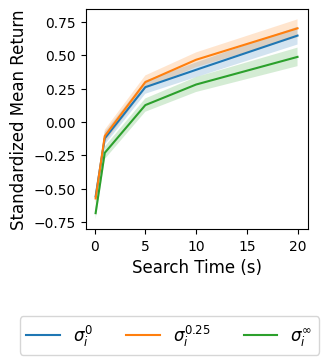

In [8]:
fig_kwargs = {"figsize": (PAGE_COL_WIDTH, 3.7)}
subplot_kwargs = {
    "ylabel": "Standardized Mean Return",
    "xlabel": "Search Time (s)"
}

num_rows = 1
num_cols = 1
fig, ax = plt.subplots(
    nrows=num_rows,
    ncols=num_cols,
    squeeze=True,
    subplot_kw=subplot_kwargs,
    **fig_kwargs,
)

paper_utils.plot_meta_policy_performance(
    meta_pi_exp_df,
    ax,
    x_key="search_time_limit",
    y_key="standardized_episode_return_mean",
    y_err_key="standardized_episode_return_CI",
    meta_pi_label_map=meta_pi_label_map,
)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol=3, loc="lower right")

fig.tight_layout(rect=(0.0, 0.18, 1.0, 1.0))
fig.savefig(osp.join(figure_dir, f"shared_meta_pi_standardize_return.png"))


# Meta vs fixed policy performance

In [9]:
meta_fixed_pi_label_map = {
    "Driving": {
        "baposgmcp_metasoftmax": r"$\sigma_{i}^{0.25}$",
        "baposgmcp-random": "Random",
        "baposgmcp-fixed_piklrk0seed0-v0": r"$\pi_{0}$", 
        "baposgmcp-fixed_piklrk1seed0-v0": r"$\pi_{1}$", 
        "baposgmcp-fixed_piklrk2seed0-v0": r"$\pi_{2}$",
        "baposgmcp-fixed_piklrk3seed0-v0": r"$\pi_{3}$",
        "baposgmcp-fixed_piklrk4seed0-v0": r"$\pi_{4}$",
    },
    "PE (Evader)": {
        "baposgmcp_metasoftmax": r"$\sigma_{i}^{0.25}$",
        "baposgmcp-random": "Random",
        "baposgmcp-fixed_piklrk0seed0i0-v0": r"$\pi_{0}$",
        "baposgmcp-fixed_piklrk1seed0i0-v0": r"$\pi_{1}$",
        "baposgmcp-fixed_piklrk2seed0i0-v0": r"$\pi_{2}$",
        "baposgmcp-fixed_piklrk3seed0i0-v0": r"$\pi_{3}$",
        "baposgmcp-fixed_piklrk4seed0i0-v0": r"$\pi_{4}$",
    },
    "PE (Pursuer)": {
        "baposgmcp_metasoftmax": r"$\sigma_{i}^{0.25}$",
        "baposgmcp-random": "Random",
        "baposgmcp-fixed_piklrk0seed0i1-v0": r"$\pi_{0}$",
        "baposgmcp-fixed_piklrk1seed0i1-v0": r"$\pi_{1}$",
        "baposgmcp-fixed_piklrk2seed0i1-v0": r"$\pi_{2}$",
        "baposgmcp-fixed_piklrk3seed0i1-v0": r"$\pi_{3}$",
        "baposgmcp-fixed_piklrk4seed0i1-v0": r"$\pi_{4}$",
    },
    "PP (two-agents)": {
        "baposgmcp_metasoftmax": r"$\sigma_{i}^{0.25}$",
        "baposgmcp-random": "Random",
        "baposgmcp-fixed_pispseed0-v0": r"$\pi_{0}$", 
        "baposgmcp-fixed_pispseed1-v0": r"$\pi_{1}$", 
        "baposgmcp-fixed_pispseed2-v0": r"$\pi_{2}$",
        "baposgmcp-fixed_pispseed3-v0": r"$\pi_{3}$",
        "baposgmcp-fixed_pispseed4-v0": r"$\pi_{4}$",
    }, 
    "PP (four-agents)": {
        "baposgmcp_metasoftmax": r"$\sigma_{i}^{0.25}$",
        "baposgmcp-random": "Random",
        "baposgmcp-fixed_pispseed0-v0": r"$\pi_{0}$", 
        "baposgmcp-fixed_pispseed1-v0": r"$\pi_{1}$", 
        "baposgmcp-fixed_pispseed2-v0": r"$\pi_{2}$",
        "baposgmcp-fixed_pispseed3-v0": r"$\pi_{3}$",
        "baposgmcp-fixed_pispseed4-v0": r"$\pi_{4}$",
    }
}

meta_fixed_pi_best_worst_label_map = {
    "Driving": {
        "baposgmcp_metasoftmax": r"$\sigma_{i}^{0.25}$",
        "baposgmcp-random": "Random",
        "baposgmcp-fixed_piklrk0seed0-v0": "Worst",  
        "baposgmcp-fixed_piklrk2seed0-v0": "Best",
    },
    "PE (Evader)": {
        "baposgmcp_metasoftmax": r"$\sigma_{i}^{0.25}$",
        "baposgmcp-random": "Random",
        "baposgmcp-fixed_piklrk0seed0i0-v0": "Worst",
        "baposgmcp-fixed_piklrk4seed0i0-v0": "Best",
    },
    "PE (Pursuer)": {
        "baposgmcp_metasoftmax": r"$\sigma_{i}^{0.25}$",
        "baposgmcp-random": "Random",
        "baposgmcp-fixed_piklrk0seed0i1-v0": "Worst",
        "baposgmcp-fixed_piklrk2seed0i1-v0": "Best",
    },
    "PP (two-agents)": {
        "baposgmcp_metasoftmax": r"$\sigma_{i}^{0.25}$",
        "baposgmcp-random": "Random",
        "baposgmcp-fixed_pispseed1-v0": "Worst",
        "baposgmcp-fixed_pispseed4-v0": "Best",
    }, 
    "PP (four-agents)": {
        "baposgmcp_metasoftmax": r"$\sigma_{i}^{0.25}$",
        "baposgmcp-random": "Random",
        "baposgmcp-fixed_pispseed0-v0": "Worst", 
        "baposgmcp-fixed_pispseed3-v0": "Best", 
    }
}

pi_group_label_map = {
    "baposgmcp_metasoftmax": r"$\sigma_{i}^{0.25}$",
    "baposgmcp-random": "Random",
    "baposgmcp-fixed_best": "Best",
    "baposgmcp-fixed_worst": "Worst",
}


def get_meta_fixed_df(df, env_label):
    pi_map = meta_fixed_pi_best_worst_label_map[env_label]
    best_fixed_pi_id_prefix = [k for k, v in pi_map.items() if v == "Best"][0]
    worst_fixed_pi_id_prefix = [k for k, v in pi_map.items() if v == "Worst"][0]
    
    df = df[
        ((df["alg_id"] == "baposgmcp") & (df["meta_pi"] == "softmax") & (df["truncated"] == True))
        | ((df["alg_id"] == "baposgmcp-fixed") & (df["truncated"] == True))
        | ((df["alg_id"] == "baposgmcp-random") & (df["truncated"] == False))
    ]
    
    def add_pi_group(row):
        pi_id = row["policy_id"]
        tokens = pi_id.split("_")
        if pi_id.startswith("baposgmcp-random"):
            group = pi_id
        elif pi_id.startswith("baposgmcp_meta"):
            group = pi_id
        elif pi_id.startswith(best_fixed_pi_id_prefix):
            tokens[1] = "best"
            group = "_".join(tokens)
        elif pi_id.startswith(worst_fixed_pi_id_prefix):
            tokens[1] = "worst"
            group = "_".join(tokens)
        else:
            tokens[1] = "other"
            group = "_".join(tokens)
        return group
            
    df["policy_group"] = df.apply(add_pi_group, axis=1)
    
    search_times = df["search_time_limit"].unique().tolist()
    search_times.sort()
    
    return_means = {}
    for n in search_times:
        n_df = df[df["search_time_limit"] == n]
        return_means[n] = df["episode_return_mean"].mean()
        
    pprint(return_means)
    print()
    policy_ids = df["policy_id"].unique().tolist()
    policy_ids.sort()
    for pi_id in policy_ids:
        pi_group = df[df["policy_id"] == pi_id]["policy_group"].unique().tolist()
        print(pi_id, pi_group)
    
    df["standardized_episode_return_mean"] = df.apply(
        lambda row: add_standardized_return(row, return_means), axis=1
    )
    df["standardized_episode_return_CI"] = df.apply(
        lambda row: add_standardized_CI(row), axis=1
    )
        
    return df
      
        
meta_fixed_dfs = {}
for env_id, env_df in meta_exp_dfs.items():
    env_info = env_info_map[env_id]
    print(env_id, env_info.label)
    meta_fixed_dfs[env_info.label] = get_meta_fixed_df(env_df, env_info.label)

driving Driving
{0.1: 1.9206512892216738,
 1.0: 1.9206512892216738,
 5.0: 1.9206512892216738,
 10.0: 1.9206512892216738,
 20.0: 1.9206512892216738}

baposgmcp-fixed_piklrk0seed0-v0_searchtimelimit0.1_truncatedTrue ['baposgmcp-fixed_worst_searchtimelimit0.1_truncatedTrue']
baposgmcp-fixed_piklrk0seed0-v0_searchtimelimit10_truncatedTrue ['baposgmcp-fixed_worst_searchtimelimit10_truncatedTrue']
baposgmcp-fixed_piklrk0seed0-v0_searchtimelimit1_truncatedTrue ['baposgmcp-fixed_worst_searchtimelimit1_truncatedTrue']
baposgmcp-fixed_piklrk0seed0-v0_searchtimelimit20_truncatedTrue ['baposgmcp-fixed_worst_searchtimelimit20_truncatedTrue']
baposgmcp-fixed_piklrk0seed0-v0_searchtimelimit5_truncatedTrue ['baposgmcp-fixed_worst_searchtimelimit5_truncatedTrue']
baposgmcp-fixed_piklrk1seed0-v0_searchtimelimit0.1_truncatedTrue ['baposgmcp-fixed_other_searchtimelimit0.1_truncatedTrue']
baposgmcp-fixed_piklrk1seed0-v0_searchtimelimit10_truncatedTrue ['baposgmcp-fixed_other_searchtimelimit10_truncatedTrue

## Meta vs Fixed policy Performance by environment

Performance of POTMMCP with softmax meta-policy, random policy, and the fixed policies, in each environment.

Driving
PE (Evader)
PE (Pursuer)
PP (two-agents)
PP (four-agents)
Driving
PE (Evader)
PE (Pursuer)
PP (two-agents)
PP (four-agents)


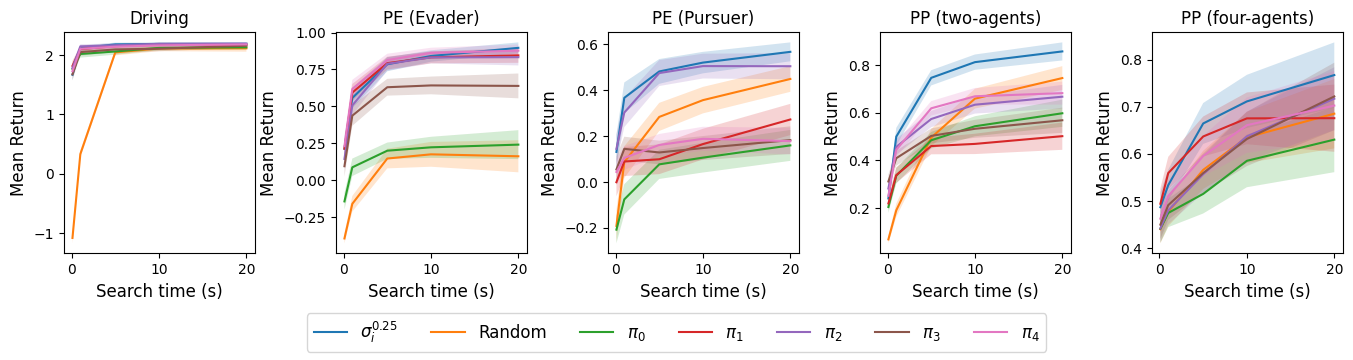

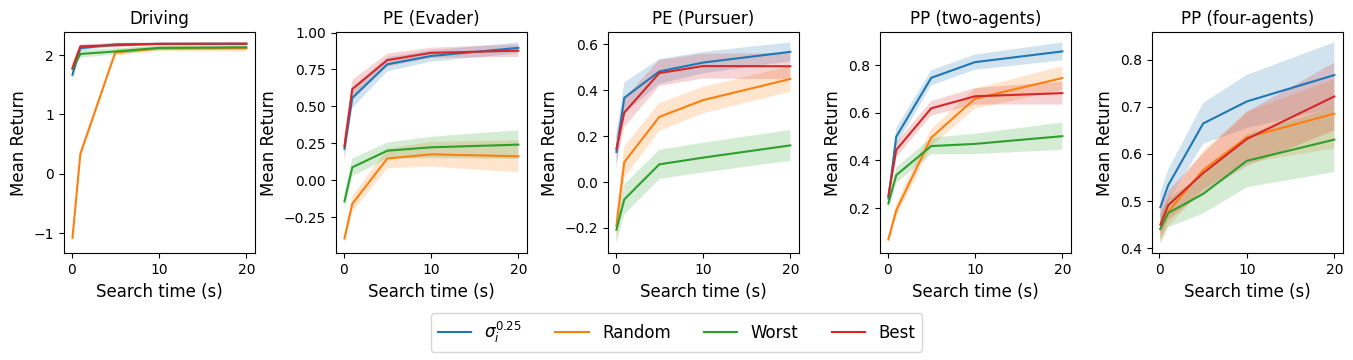

In [10]:
fig_kwargs = {"figsize": (PAGE_WIDTH*2, 3.5)}
subplot_kwargs = {
    "ylabel": "Mean Return",
    "xlabel": "Search time (s)"
}

num_rows = 1
num_cols = len(meta_fixed_dfs)

for env_pi_label_map, fig_label in [
    (meta_fixed_pi_label_map, "shared_meta_vs_all_fixed_pi_return.png"),
    (meta_fixed_pi_best_worst_label_map, "shared_meta_vs_best_worst_fixed_pi_return.png")
]:
    fig, axs = plt.subplots(
        nrows=num_rows,
        ncols=num_cols,
        squeeze=False,
        subplot_kw=subplot_kwargs,
        **fig_kwargs,
    )

    for i, (env_label, env_df) in enumerate(meta_fixed_dfs.items()):
        print(env_label)
        env_pi_labels = env_pi_label_map[env_label]
        ax = axs[0][i]
        paper_utils.plot_performance(
            env_df,
            ax=ax,
            x_key="search_time_limit",
            y_key="episode_return_mean",
            y_err_key="episode_return_CI",
            policy_prefixes=list(env_pi_labels),
            pi_label_map=env_pi_labels,
            constant_policy_prefixes=[],
            policy_key="policy_id",
        )
        ax.set_title(env_label)

    handles, labels = axs[0][0].get_legend_handles_labels()
    fig.legend(handles, labels, ncol=7, loc="lower center")

    fig.tight_layout(pad=0.1, w_pad=0.8, h_pad=1.0, rect=(0.0, 0.16, 1.0, 1.0))
    fig.savefig(osp.join(figure_dir, fig_label))

## Standardized Meta-policy vs fixed policy performance

In [11]:
concated_meta_fixed_df = pd.concat(list(meta_fixed_dfs.values()))
get_df_info(concated_meta_fixed_df)
    
agg_dict = plot_utils.get_uniform_expected_agg_map(concated_meta_fixed_df)
for k in ["policy_group"]:
    if k in agg_dict:
        del agg_dict[k]

gb = concated_meta_fixed_df.groupby(["policy_group"])
gb_agg = gb.agg(**agg_dict)

print("\nUngrouped size =", len(concated_meta_fixed_df))
averaged_meta_fixed_df = gb_agg.reset_index()
print("Grouped size =", len(averaged_meta_fixed_df ))

print()
new_policy_groups = averaged_meta_fixed_df["policy_group"].unique().tolist()
new_policy_groups.sort()
for pi_gp in new_policy_groups:
    print(pi_gp)
    
assert len(new_policy_groups) == len(averaged_meta_fixed_df)


Alg IDs
-------
baposgmcp
baposgmcp-fixed
baposgmcp-random

Policy IDs
----------
baposgmcp-fixed_piklrk0seed0-v0_searchtimelimit0.1_truncatedTrue
baposgmcp-fixed_piklrk0seed0-v0_searchtimelimit10_truncatedTrue
baposgmcp-fixed_piklrk0seed0-v0_searchtimelimit1_truncatedTrue
baposgmcp-fixed_piklrk0seed0-v0_searchtimelimit20_truncatedTrue
baposgmcp-fixed_piklrk0seed0-v0_searchtimelimit5_truncatedTrue
baposgmcp-fixed_piklrk0seed0i0-v0_searchtimelimit0.1_truncatedTrue
baposgmcp-fixed_piklrk0seed0i0-v0_searchtimelimit10_truncatedTrue
baposgmcp-fixed_piklrk0seed0i0-v0_searchtimelimit1_truncatedTrue
baposgmcp-fixed_piklrk0seed0i0-v0_searchtimelimit20_truncatedTrue
baposgmcp-fixed_piklrk0seed0i0-v0_searchtimelimit5_truncatedTrue
baposgmcp-fixed_piklrk0seed0i1-v0_searchtimelimit0.1_truncatedTrue
baposgmcp-fixed_piklrk0seed0i1-v0_searchtimelimit10_truncatedTrue
baposgmcp-fixed_piklrk0seed0i1-v0_searchtimelimit1_truncatedTrue
baposgmcp-fixed_piklrk0seed0i1-v0_searchtimelimit20_truncatedTrue
baposg

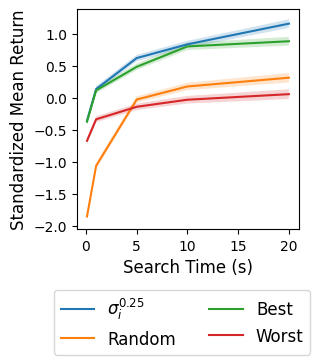

In [12]:
fig_kwargs = {"figsize": (PAGE_COL_WIDTH, 3.7)}
subplot_kwargs = {
    "ylabel": "Standardized Mean Return",
    "xlabel": "Search Time (s)"
}

num_rows = 1
num_cols = 1
fig, ax = plt.subplots(
    nrows=num_rows,
    ncols=num_cols,
    squeeze=True,
    subplot_kw=subplot_kwargs,
    **fig_kwargs,
)

paper_utils.plot_performance(
    averaged_meta_fixed_df,
    ax,
    x_key="search_time_limit",
    y_key="standardized_episode_return_mean",
    y_err_key="standardized_episode_return_CI",
    policy_prefixes=list(pi_group_label_map),
    pi_label_map=pi_group_label_map,
    constant_policy_prefixes=[],
    policy_key="policy_group",
)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol=2, loc="lower right")

fig.tight_layout(rect=(0.0, 0.18, 1.0, 1.0))
fig.savefig(osp.join(figure_dir, f"shared_meta_fixed_standardize_return.png"))

# Baseline performance vs search time

In [13]:
for env_id, env_df in baseline_exp_dfs.items():
    env_info = env_info_map[env_id]
    print("\n##########")
    print(env_info.label)
    print("##########")
    get_df_info(env_df)


##########
Driving
##########
Alg IDs
-------
baposgmcp
baposgmcp-random
fixed
full-knowledge-br
metabaseline
ucbmcp
ucbmcp-random

Policy IDs
----------
baposgmcp-random_searchtimelimit0.1_truncatedFalse
baposgmcp-random_searchtimelimit10_truncatedFalse
baposgmcp-random_searchtimelimit1_truncatedFalse
baposgmcp-random_searchtimelimit20_truncatedFalse
baposgmcp-random_searchtimelimit5_truncatedFalse
baposgmcp_metasoftmax_searchtimelimit0.1_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit10_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit1_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit20_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit5_truncatedTrue
full-knowledge-br
klr_k0_seed0-v0
klr_k1_seed0-v0
klr_k2_seed0-v0
klr_k3_seed0-v0
klr_k4_seed0-v0
metabaseline_softmax
ucbmcp-random_searchtimelimit0.1_truncatedFalse
ucbmcp-random_searchtimelimit10_truncatedFalse
ucbmcp-random_searchtimelimit1_truncatedFalse
ucbmcp-random_searchtimelimit20_truncatedFalse
ucbmcp-random_search

Driving
PE (Evader)
PE (Pursuer)
PP (two-agents)
PP (four-agents)


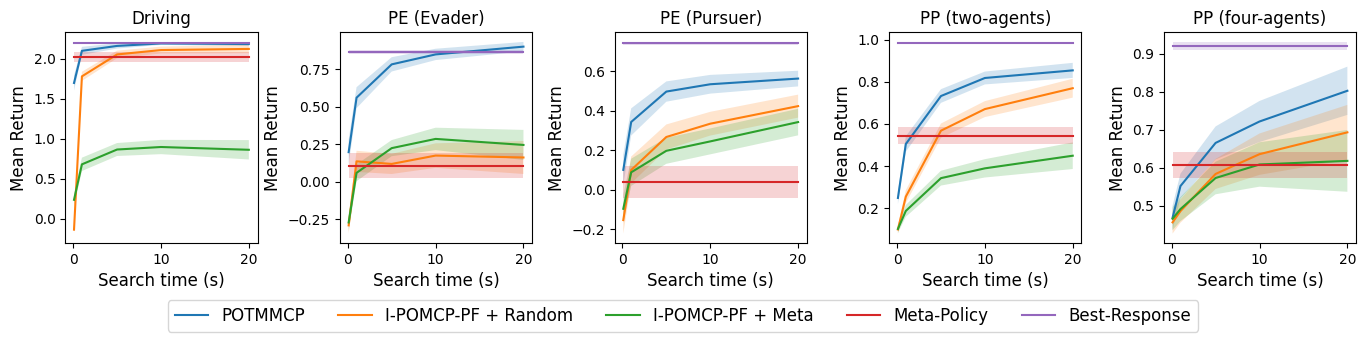

In [14]:
best_meta_pi = "softmax"

baseline_policy_prefixes_to_plot = [
    f"baposgmcp_meta{best_meta_pi}",
    # "baposgmcp-random",
    "ucbmcp-random",
    f"ucbmcp_meta{best_meta_pi}",
    f"metabaseline_{best_meta_pi}",
    f"full-knowledge-br",   
]
constant_policy_prefixes = [
    f"metabaseline_{best_meta_pi}",
    f"full-knowledge-br",
]

baseline_pi_label_map = {
    f"baposgmcp_meta{best_meta_pi}": algname,
    # "baposgmcp-random": f"{algname} + Random", 
    "full-knowledge-br": "Best-Response",
    f"metabaseline_{best_meta_pi}": "Meta-Policy",
    f"ucbmcp_meta{best_meta_pi}": f"{baselinealgname} + Meta",
    "ucbmcp-random": f"{baselinealgname} + Random"
}

fig_kwargs = {"figsize": (PAGE_WIDTH*2, 3.3)}
subplot_kwargs = {
    "ylabel": "Mean Return",
    "xlabel": "Search time (s)"
}


num_rows = 1
num_cols = len(baseline_exp_dfs)

fig, axs = plt.subplots(
    nrows=num_rows,
    ncols=num_cols,
    squeeze=False,
    subplot_kw=subplot_kwargs,
    **fig_kwargs,
)

for i, (env_id, env_df) in enumerate(baseline_exp_dfs.items()):
    env_info = env_info_map[env_id]
    print(env_info.label)
    ax = axs[0][i]
    paper_utils.plot_performance(
        env_df,
        ax=ax,
        x_key="search_time_limit",
        y_key="episode_return_mean",
        y_err_key="episode_return_CI",
        policy_key="policy_id",
        policy_prefixes=baseline_policy_prefixes_to_plot,
        constant_policy_prefixes=constant_policy_prefixes,
        pi_label_map=baseline_pi_label_map,
    )
    ax.set_title(env_info.label)
    
handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=5, loc="lower center")

fig.tight_layout(pad=0.1, w_pad=0.9, h_pad=1.0, rect=(0.0, 0.14, 1.0, 1.0))
fig.savefig(osp.join(figure_dir, "shared_baselines_return_vs_search_time.png"))

# Search Depth

In [15]:
concated_baseline_df = pd.concat(list(baseline_exp_dfs.values()))
get_df_info(concated_baseline_df)
    
agg_dict = plot_utils.get_uniform_expected_agg_map(concated_baseline_df)
gb = concated_baseline_df.groupby(["policy_id"])
gb_agg = gb.agg(**agg_dict)

print("\nUngrouped size =", len(concated_baseline_df))
avg_baseline_df = gb_agg.reset_index()
print("Grouped size =", len(avg_baseline_df ))

new_policies = set(avg_baseline_df ["policy_id"].unique().tolist())
assert len(new_policies) == len(avg_baseline_df), "Should be one row per policy ID"

Alg IDs
-------
baposgmcp
baposgmcp-random
fixed
full-knowledge-br
metabaseline
ucbmcp
ucbmcp-random

Policy IDs
----------
baposgmcp-random_searchtimelimit0.1_truncatedFalse
baposgmcp-random_searchtimelimit10_truncatedFalse
baposgmcp-random_searchtimelimit1_truncatedFalse
baposgmcp-random_searchtimelimit20_truncatedFalse
baposgmcp-random_searchtimelimit5_truncatedFalse
baposgmcp_metasoftmax_searchtimelimit0.1_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit10_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit1_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit20_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit5_truncatedTrue
full-knowledge-br
klr_k0_seed0
klr_k0_seed0-v0
klr_k1_seed0
klr_k1_seed0-v0
klr_k2_seed0
klr_k2_seed0-v0
klr_k3_seed0
klr_k3_seed0-v0
klr_k4_seed0
klr_k4_seed0-v0
metabaseline_softmax
sp_seed0-v0
sp_seed1-v0
sp_seed2-v0
sp_seed3-v0
sp_seed4-v0
ucbmcp-random_searchtimelimit0.1_truncatedFalse
ucbmcp-random_searchtimelimit10_truncatedFalse
ucbmcp-random_searc

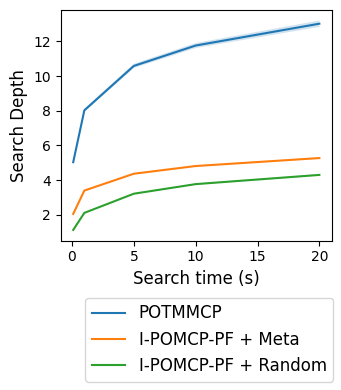

In [16]:
best_meta_pi = "softmax"
search_depth_pi_label_map = {
    f"baposgmcp_meta{best_meta_pi}": algname,
    # f"baposgmcp-random": f"{algname} + Random",
    f"ucbmcp_meta{best_meta_pi}": f"{baselinealgname} + Meta",
    "ucbmcp-random": f"{baselinealgname} + Random"
}

fig_kwargs = {"figsize": (PAGE_COL_WIDTH, 3.8)}
subplot_kwargs = {
    "ylabel": "Search Depth",
    "xlabel": "Search time (s)"
}

num_rows = 1
num_cols = 1

fig, ax = plt.subplots(
    nrows=num_rows,
    ncols=num_cols,
    squeeze=True,
    subplot_kw=subplot_kwargs,
    **fig_kwargs,
)

paper_utils.plot_performance(
    avg_baseline_df,
    ax=ax,
    x_key="search_time_limit",
    y_key="search_depth_mean",
    y_err_key="search_depth_CI",
    policy_key="policy_id",
    policy_prefixes=list(search_depth_pi_label_map),
    constant_policy_prefixes=[],
    pi_label_map=search_depth_pi_label_map,
)
    
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol=1, loc="lower right")

fig.tight_layout(pad=0.1, w_pad=0.8, h_pad=1.0, rect=(0.0, 0.26, 1.0, 1.0))
fig.savefig(osp.join(figure_dir, "shared_search_depth_vs_search_time.png"))

del fig_kwargs
del subplot_kwargs

# Belief Accuracy

In [17]:
belief_dfs = {}
for env_id, env_df in baseline_exp_dfs.items():
    env_info = env_info_map[env_id]
    belief_dfs[env_info.label] = env_df[
        (env_df["alg_id"] == "baposgmcp") & (env_df["meta_pi"] == "softmax") & (env_df["truncated"] == True)
    ]

for env_label, env_df in belief_dfs.items():
    print("\n##########")
    print(env_label)
    print("##########")
    get_df_info(env_df)


##########
Driving
##########
Alg IDs
-------
baposgmcp

Policy IDs
----------
baposgmcp_metasoftmax_searchtimelimit0.1_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit10_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit1_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit20_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit5_truncatedTrue

##########
PE (Evader)
##########
Alg IDs
-------
baposgmcp

Policy IDs
----------
baposgmcp_metasoftmax_searchtimelimit0.1_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit10_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit1_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit20_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit5_truncatedTrue

##########
PE (Pursuer)
##########
Alg IDs
-------
baposgmcp

Policy IDs
----------
baposgmcp_metasoftmax_searchtimelimit0.1_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit10_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit1_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit20_truncatedTr

In [18]:
for env_label, env_df in belief_dfs.items():
    print(f"\n{env_label}")
    sts = env_df["search_time_limit"].unique().tolist()
    sts.sort()
    for st in sts:
        print(st, "-", env_df[env_df["search_time_limit"] == st]["episode_steps_mean"].tolist())


Driving
0.1 - [23.565625]
1.0 - [20.620625]
5.0 - [20.48]
10.0 - [20.91375]
20.0 - [20.937901145435895]

PE (Evader)
0.1 - [23.704375]
1.0 - [27.945625]
5.0 - [32.366875]
10.0 - [32.54038043478261]
20.0 - [33.11045511451184]

PE (Pursuer)
0.1 - [24.47]
1.0 - [18.4325]
5.0 - [15.546875]
10.0 - [14.775]
20.0 - [13.65713028169014]

PP (two-agents)
0.1 - [48.846]
1.0 - [45.163]
5.0 - [39.778]
10.0 - [37.90069607133403]
20.0 - [36.83365963922764]

PP (four-agents)
0.1 - [47.972]
1.0 - [46.785]
5.0 - [44.195396366423694]
10.0 - [42.67211400667343]
20.0 - [40.81678423163523]


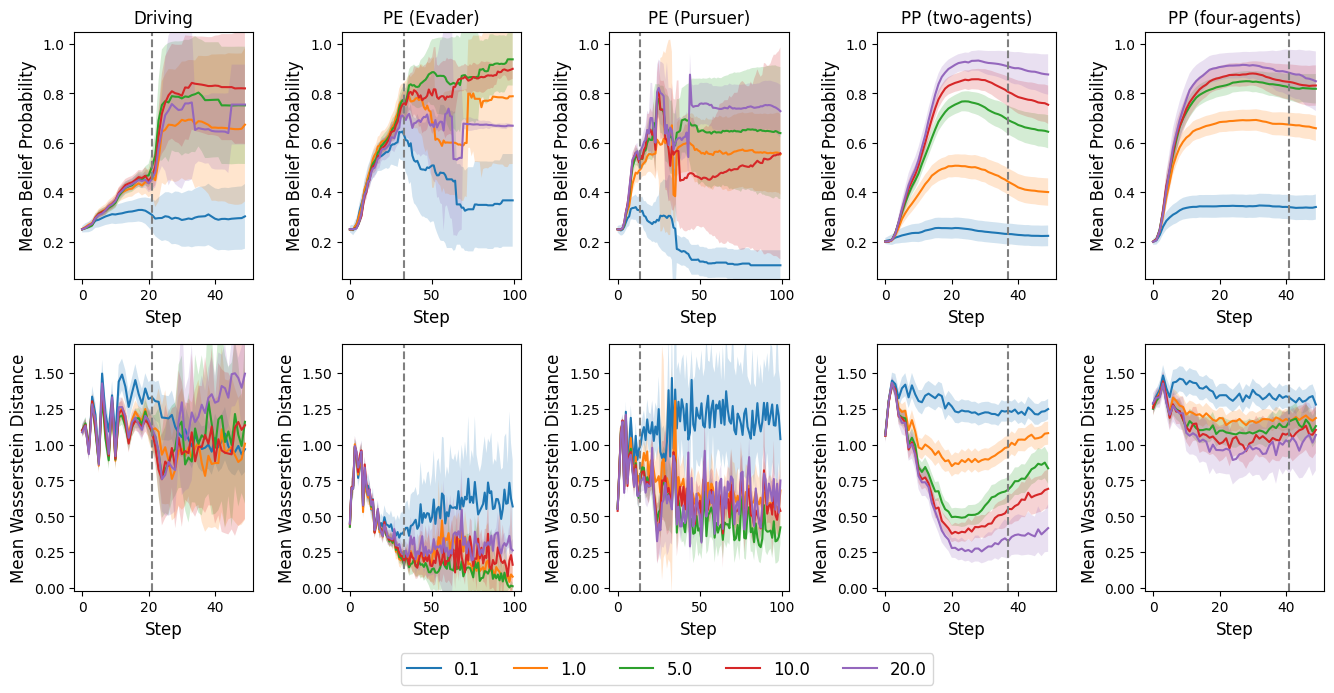

In [19]:
fig_kwargs = {"figsize": (PAGE_WIDTH*2, 7)}
subplot_kwargs = {
    "xlabel": "Step"
}

num_rows = 2
num_cols = len(belief_dfs)
fig, axs = plt.subplots(
    nrows=num_rows,
    ncols=num_cols,
    squeeze=False,
    subplot_kw=subplot_kwargs,
    **fig_kwargs,
)

y_lims = [(0.05, 1.05), (-0.02, 1.7)]
y_labels = ["Mean Belief Probability", "Mean Wasserstein Distance"]
env_step_limits = {
    "Driving": 50,
    "PE (Evader)": 100,
    "PE (Pursuer)": 100,
    "PP (two-agents)": 50,
    "PP (four-agents)": 50,
}
env_other_agent_id = {
    "Driving": 1,
    "PE (Evader)": 1,
    "PE (Pursuer)": 0,
    "PP (two-agents)": 1,
    "PP (four-agents)": 1,
}
# mean steps taken for POTMMCP with 20.0 seconds planning time
env_mean_steps = {
    "Driving": 20.94,
    "PE (Evader)": 33.11,
    "PE (Pursuer)": 13.66,
    "PP (two-agents)": 36.83,
    "PP (four-agents)": 40.82,
}


for i, (env_label, env_df) in enumerate(belief_dfs.items()):
    paper_utils.plot_expected_belief_stat_by_step(
        env_df,
        axs[0][i],
        z_key="search_time_limit",
        y_key_prefix="bayes_accuracy",
        step_limit=env_step_limits[env_label],
        other_agent_id=env_other_agent_id[env_label],
        y_suffix="mean",
        y_err_suffix="CI",
    )
    axs[0][i].set_ylabel(y_labels[0])
    axs[0][i].set_ylim(y_lims[0])

    paper_utils.plot_expected_belief_stat_by_step(
        env_df,
        axs[1][i],
        z_key="search_time_limit",
        y_key_prefix="action_dist_distance",
        step_limit=env_step_limits[env_label],
        other_agent_id=env_other_agent_id[env_label],
        y_suffix="mean",
        y_err_suffix="CI",
    )
    axs[1][i].set_ylabel(y_labels[1])
    axs[1][i].set_ylim(y_lims[1])
    axs[0][i].set_title(env_label)
    
    axs[0][i].axvline(env_mean_steps[env_label], linestyle="--", color="grey")
    axs[1][i].axvline(env_mean_steps[env_label], linestyle="--", color='grey')

handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=5, loc="lower center")

fig.tight_layout(rect=(0.0, 0.05, 1.0, 1.0))
fig.savefig(osp.join(figure_dir, f"shared_bayes_accuracy.png"))
    
del fig_kwargs
del subplot_kwargs

# Environment diagrams

In [20]:
import posggym

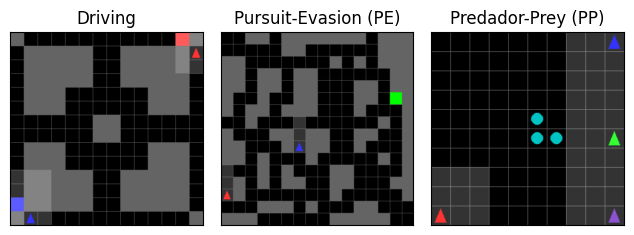

In [21]:
def plot_environment(env_id: str, ax):
    # Turn off x/y axis numbering/ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    env = posggym.make(env_id)
    env_img = env.render(mode='rgb_array')

    if isinstance(env_img, tuple):
        # render returns img for each agent
        # env img is 0th by default
        env_img = env_img[0]

    imshow_obj = ax.imshow(
        env_img, interpolation='bilinear', origin='upper'
    )
    imshow_obj.set_data(env_img)
    env.close()
    return ax

fig_kwargs = {"figsize": (PAGE_COL_WIDTH*2, 2.35)}
subplot_kwargs = {}

env_ids_to_plot = {
    "Driving14x14WideRoundAbout-n2-v0": "Driving",
    "PursuitEvasion16x16-v0": "Pursuit-Evasion (PE)",
    # "PredatorPrey10x10-P2-p3-s2-coop-v0": "PP (two-agents)",
    "PredatorPrey10x10-P4-p3-s3-coop-v0": "Predador-Prey (PP)",
}

num_rows = 1
num_cols = len(env_ids_to_plot)
fig, axs = plt.subplots(
    nrows=num_rows,
    ncols=num_cols,
    squeeze=False,
    subplot_kw=subplot_kwargs,
    **fig_kwargs,
)

for i, (env_id, env_label) in enumerate(env_ids_to_plot.items()):
    ax = axs[0][i]
    plot_environment(env_id, ax)
    ax.set_title(env_label)
    
fig.tight_layout(rect=(0.0, 0.00, 1.0, 1.0))
fig.savefig(osp.join(figure_dir, f"envs.png"))
    
del fig_kwargs
del subplot_kwargs